---
## 1. Environment Setup and Data Loading <a id='section1'></a>

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# XGBoost specific imports
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance, plot_tree

# Scikit-learn utilities
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Check XGBoost version and capabilities
print(f"XGBoost Version: {xgb.__version__}")
print(f"GPU Available: {xgb.build_info()['USE_CUDA'] if 'USE_CUDA' in xgb.build_info() else 'N/A'}")
print(f"OpenMP Available: {xgb.build_info()['USE_OPENMP'] if 'USE_OPENMP' in xgb.build_info() else 'N/A'}")

XGBoost Version: 2.1.1
GPU Available: False
OpenMP Available: True


In [49]:
df = pd.read_csv('marketing_campaign.csv', sep='\t')

print(f"Dataset Shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Dataset Shape: (2240, 29)

First few rows:


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


## 2. Exploratory Data Analysis <a id='section2'></a>

In [50]:
print("Dataset Info:")
print("="*50)
df.info()

print("\n" + "="*50)
print("Statistical Summary:")
print("="*50)
df.describe()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    224

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2240.000000,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,...,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000
mean,5592.159821,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,...,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,3.0,11.0,0.149107
std,3246.662198,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,...,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.0,0.0,0.356274
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,2828.250000,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,...,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,8427.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,...,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,...,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000


Missing Values Analysis:
        Missing Values  Percentage
Income              24    1.071429


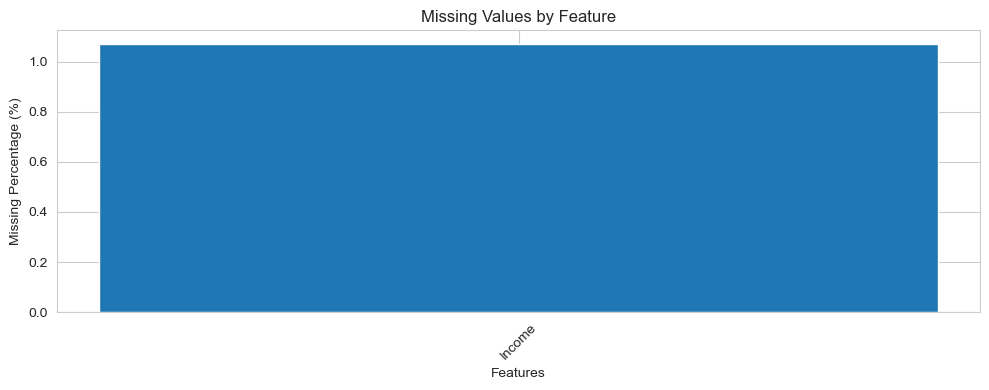

In [51]:
# Check for missing values
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})
missing_df = missing_df[missing_df['Missing Values'] > 0].sort_values('Missing Values', ascending=False)

print("Missing Values Analysis:")
print(missing_df)

# Visualize missing values
if not missing_df.empty:
    plt.figure(figsize=(10, 4))
    plt.bar(missing_df.index, missing_df['Percentage'])
    plt.xlabel('Features')
    plt.ylabel('Missing Percentage (%)')
    plt.title('Missing Values by Feature')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Campaign columns: ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Response']


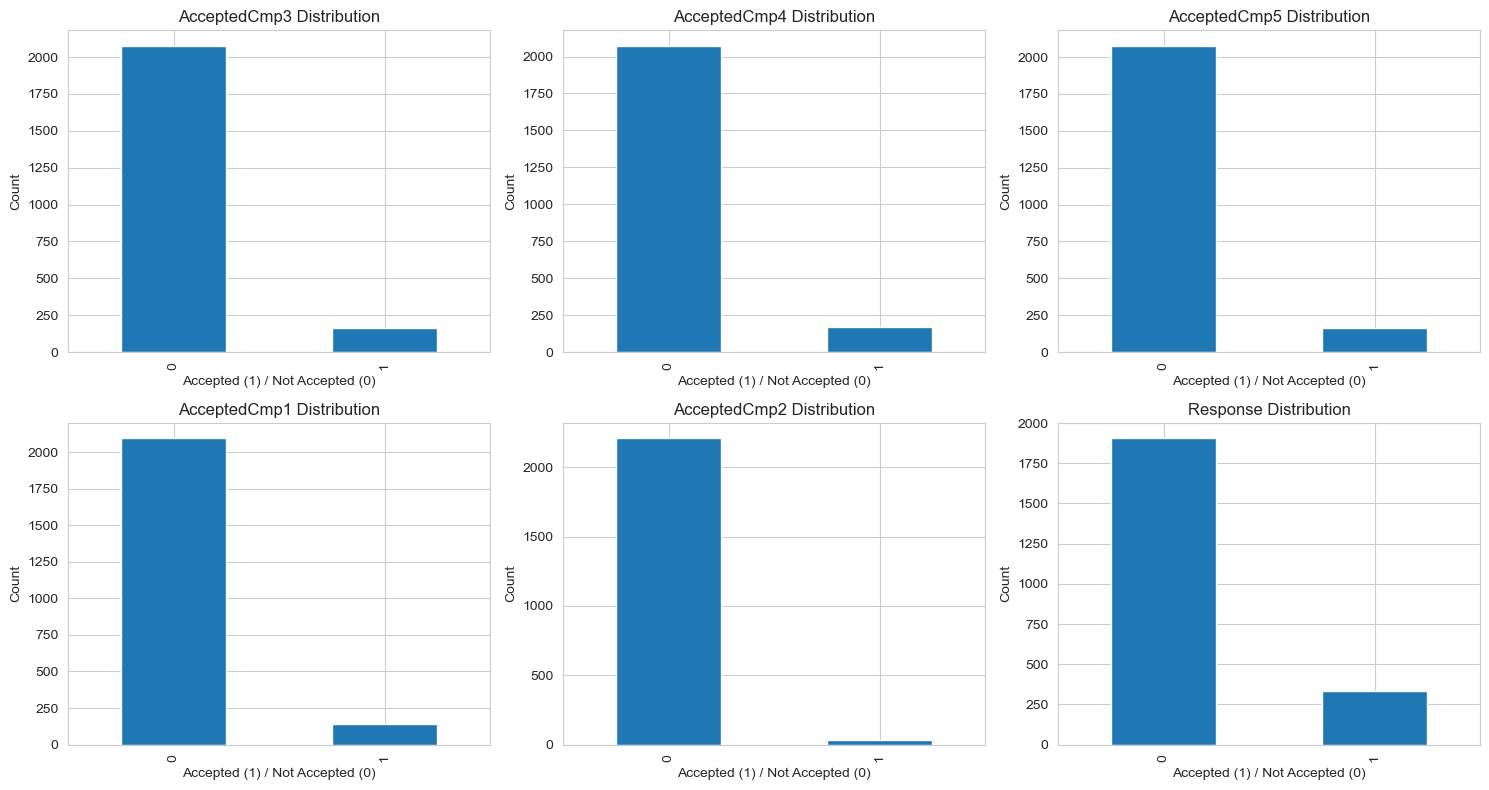

In [52]:
# Analyze the response variable - we'll predict if customer accepted any campaign
# Create target variable: 1 if customer accepted any campaign, 0 otherwise
campaign_cols = [col for col in df.columns if 'AcceptedCmp' in col or col == 'Response']
print(f"Campaign columns: {campaign_cols}")

# Visualize campaign acceptance distribution
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

for idx, col in enumerate(campaign_cols):
    if idx < len(axes):
        df[col].value_counts().plot(kind='bar', ax=axes[idx])
        axes[idx].set_title(f'{col} Distribution')
        axes[idx].set_xlabel('Accepted (1) / Not Accepted (0)')
        axes[idx].set_ylabel('Count')

plt.tight_layout()
plt.show()


## 3. Data Preprocessing <a id='section3'></a>

### 3.1 Feature Engineering and Cleaning

In [53]:
# Create a copy for preprocessing
df_processed = df.copy()

# 1. Handle missing values in 'Income'
print(f"Missing Income values: {df_processed['Income'].isnull().sum()}")
df_processed['Income'].fillna(df_processed['Income'].median(), inplace=True)

# 2. Create target variable: Accept any campaign
df_processed['AcceptedAnyCampaign'] = df_processed[campaign_cols].max(axis=1)
print(f"\nTarget Variable Distribution:")
print(df_processed['AcceptedAnyCampaign'].value_counts())
print(f"Class Balance: {df_processed['AcceptedAnyCampaign'].value_counts(normalize=True)}")

# Age from birth year
current_year = 2014  # Dataset is from around 2014
df_processed['Age'] = current_year - df_processed['Year_Birth']

spending_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 
                 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
df_processed['TotalSpending'] = df_processed[spending_cols].sum(axis=1)

purchase_cols = ['NumDealsPurchases', 'NumWebPurchases', 
                 'NumCatalogPurchases', 'NumStorePurchases']
df_processed['TotalPurchases'] = df_processed[purchase_cols].sum(axis=1)

df_processed['TotalChildren'] = df_processed['Kidhome'] + df_processed['Teenhome']
df_processed['Dt_Customer'] = pd.to_datetime(df_processed['Dt_Customer'], format='mixed', dayfirst=True)
reference_date = df_processed['Dt_Customer'].max()
df_processed['CustomerTenure'] = (reference_date - df_processed['Dt_Customer']).dt.days

# Average spending per purchase
df_processed['AvgSpendingPerPurchase'] = df_processed['TotalSpending'] / (df_processed['TotalPurchases'] + 1)

print(f"\nNew Features Created:")
print(f"- Age: min={df_processed['Age'].min()}, max={df_processed['Age'].max()}")
print(f"- TotalSpending: min={df_processed['TotalSpending'].min()}, max={df_processed['TotalSpending'].max()}")
print(f"- TotalPurchases: min={df_processed['TotalPurchases'].min()}, max={df_processed['TotalPurchases'].max()}")
print(f"- CustomerTenure: min={df_processed['CustomerTenure'].min()}, max={df_processed['CustomerTenure'].max()}")

Missing Income values: 24

Target Variable Distribution:
AcceptedAnyCampaign
0    1631
1     609
Name: count, dtype: int64
Class Balance: AcceptedAnyCampaign
0    0.728125
1    0.271875
Name: proportion, dtype: float64

New Features Created:
- Age: min=18, max=121
- TotalSpending: min=5, max=2525
- TotalPurchases: min=0, max=44
- CustomerTenure: min=0, max=699


In [55]:
# 4. Handle categorical variables
print("Categorical Variables:")
categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
print(categorical_cols)

# Encode Education
education_mapping = {
    'Basic': 1,
    '2n Cycle': 2,
    'Graduation': 3,
    'Master': 4,
    'PhD': 5
}
df_processed['Education_Encoded'] = df_processed['Education'].map(education_mapping)

# Encode Marital Status
marital_mapping = {
    'Single': 1,
    'Together': 2,
    'Married': 2,
    'Divorced': 1,
    'Widow': 1,
    'Alone': 1,
    'Absurd': 1,
    'YOLO': 1
}
df_processed['Marital_Encoded'] = df_processed['Marital_Status'].map(marital_mapping)

print(f"\nEducation Encoding: {education_mapping}")
print(f"Marital Status Encoding (1=Single/Alone, 2=Partnered): {df_processed['Marital_Encoded'].value_counts()}")

Categorical Variables:
['Education', 'Marital_Status']

Education Encoding: {'Basic': 1, '2n Cycle': 2, 'Graduation': 3, 'Master': 4, 'PhD': 5}
Marital Status Encoding (1=Single/Alone, 2=Partnered): Marital_Encoded
2    1444
1     796
Name: count, dtype: int64


### 3.2 Feature Selection and Dataset Preparation

In [56]:
# Select features for modeling
# Exclude: ID, Dt_Customer, original categorical columns, and individual campaign columns
exclude_cols = ['ID', 'Year_Birth', 'Dt_Customer', 'Education', 'Marital_Status', 'Z_CostContact', 'Z_Revenue'] + campaign_cols

feature_cols = [col for col in df_processed.columns if col not in exclude_cols and col != 'AcceptedAnyCampaign']

print(f"Total Features Selected: {len(feature_cols)}")
print(f"\nFeature List:")
for i, col in enumerate(feature_cols, 1):
    print(f"{i}. {col}")

# Prepare X and y
X = df_processed[feature_cols]
y = df_processed['AcceptedAnyCampaign']

print(f"\nFeature Matrix Shape: {X.shape}")
print(f"Target Vector Shape: {y.shape}")
print(f"\nClass Distribution in Target:")
print(y.value_counts())

Total Features Selected: 24

Feature List:
1. Income
2. Kidhome
3. Teenhome
4. Recency
5. MntWines
6. MntFruits
7. MntMeatProducts
8. MntFishProducts
9. MntSweetProducts
10. MntGoldProds
11. NumDealsPurchases
12. NumWebPurchases
13. NumCatalogPurchases
14. NumStorePurchases
15. NumWebVisitsMonth
16. Complain
17. Age
18. TotalSpending
19. TotalPurchases
20. TotalChildren
21. CustomerTenure
22. AvgSpendingPerPurchase
23. Education_Encoded
24. Marital_Encoded

Feature Matrix Shape: (2240, 24)
Target Vector Shape: (2240,)

Class Distribution in Target:
AcceptedAnyCampaign
0    1631
1     609
Name: count, dtype: int64


In [57]:
# Check for any remaining issues
print("Checking for infinite values:")
inf_cols = X.columns[np.isinf(X).any()]
print(f"Columns with infinite values: {list(inf_cols)}")

# Replace infinite values if any
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

print(f"\nFinal check - Missing values in X: {X.isnull().sum().sum()}")
print(f"Missing values in y: {y.isnull().sum()}")

Checking for infinite values:
Columns with infinite values: []

Final check - Missing values in X: 0
Missing values in y: 0


In [58]:
# Split the data - using stratification to maintain class balance
# Set random seed for reproducibility
RANDOM_SEED = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_SEED,
    stratify=y  # Maintain class distribution
)

print(f"Training Set Size: {X_train.shape}")
print(f"Testing Set Size: {X_test.shape}")
print(f"\nClass Distribution in Training Set:")
print(y_train.value_counts(normalize=True))
print(f"\nClass Distribution in Testing Set:")
print(y_test.value_counts(normalize=True))

Training Set Size: (1792, 24)
Testing Set Size: (448, 24)

Class Distribution in Training Set:
AcceptedAnyCampaign
0    0.728237
1    0.271763
Name: proportion, dtype: float64

Class Distribution in Testing Set:
AcceptedAnyCampaign
0    0.727679
1    0.272321
Name: proportion, dtype: float64


## 4. Model Implementation <a id='section4'></a>

### 4.1 XGBoost with Default Parameters

In [59]:
# Initialize XGBoost classifier with default parameters
# Configure XGBoost in Random Forest mode
xgb_default = XGBClassifier(
    num_parallel_tree=100,      # Build 100 trees in parallel (RF behavior)
    learning_rate=1.0,           # Disable boosting shrinkage
    subsample=0.8,               # Bootstrap sampling
    colsample_bynode=0.8,        # Feature sampling per split
    n_estimators=1,              # Only 1 boosting round (all trees built together)
    max_depth=10,
    random_state=RANDOM_SEED,
    eval_metric='logloss'
)

print("XGBoost Default Parameters:")
print("="*60)
default_params = xgb_default.get_params()
for param, value in sorted(default_params.items()):
    print(f"{param:30s}: {value}")

XGBoost Default Parameters:
base_score                    : None
booster                       : None
callbacks                     : None
colsample_bylevel             : None
colsample_bynode              : 0.8
colsample_bytree              : None
device                        : None
early_stopping_rounds         : None
enable_categorical            : False
eval_metric                   : logloss
feature_types                 : None
gamma                         : None
grow_policy                   : None
importance_type               : None
interaction_constraints       : None
learning_rate                 : 1.0
max_bin                       : None
max_cat_threshold             : None
max_cat_to_onehot             : None
max_delta_step                : None
max_depth                     : 10
max_leaves                    : None
min_child_weight              : None
missing                       : nan
monotone_constraints          : None
multi_strategy                : None
n_estimator

In [61]:
# Train the model with default parameters
import time

print("Training XGBoost with Default Parameters...")
start_time = time.time()

xgb_default.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

training_time_default = time.time() - start_time
print(f"Training completed in {training_time_default:.2f} seconds")
print(f"Number of boosting rounds: {xgb_default.n_estimators}")
print(f"Number of features used: {xgb_default.n_features_in_}")

Training XGBoost with Default Parameters...
Training completed in 0.39 seconds
Number of boosting rounds: 1
Number of features used: 24


In [62]:
# Make predictions with default model
y_pred_default = xgb_default.predict(X_test)
y_pred_proba_default = xgb_default.predict_proba(X_test)[:, 1]

# Calculate metrics
print("Default Model Performance:")
print("="*60)
print(f"Accuracy:  {accuracy_score(y_test, y_pred_default):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_default):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_default):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_default):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_proba_default):.4f}")

Default Model Performance:
Accuracy:  0.8036
Precision: 0.7742
Recall:    0.3934
F1-Score:  0.5217
ROC-AUC:   0.8589


### 4.2 Hyperparameter Tuning

In [63]:
# Parameter grid for Random Forest mode
param_grid = {
    'max_depth': [5, 10, 15],              # Tree depth
    'num_parallel_tree': [50, 100, 150],   # Number of trees (like n_estimators in RF)
    'subsample': [0.7, 0.8, 0.9],          # Bootstrap sampling ratio
    'colsample_bynode': [0.7, 0.8, 0.9],   # Feature sampling per split
    'min_child_weight': [1, 3, 5],         # Minimum samples per leaf
}

print("Parameter Grid for Tuning:")
for param, values in param_grid.items():
    print(f"{param:20s}: {values}")
print(f"\nTotal combinations: {np.prod([len(v) for v in param_grid.values()])}")

Parameter Grid for Tuning:
max_depth           : [5, 10, 15]
num_parallel_tree   : [50, 100, 150]
subsample           : [0.7, 0.8, 0.9]
colsample_bynode    : [0.7, 0.8, 0.9]
min_child_weight    : [1, 3, 5]

Total combinations: 243


In [64]:
# Perform Grid Search with Cross-Validation
print("Starting Grid Search (may take a few minutes)...")
start_time = time.time()
grid_search = GridSearchCV(
    estimator=XGBClassifier(
        num_parallel_tree=100,
        learning_rate=1.0,
        n_estimators=1,
        random_state=RANDOM_SEED, 
        eval_metric='logloss'
    ),
    param_grid=param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

tuning_time = time.time() - start_time
print(f"\nGrid Search completed in {tuning_time:.2f} seconds")
print(f"\nBest Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"{param:20s}: {value}")
print(f"\nBest Cross-Validation F1-Score: {grid_search.best_score_:.4f}")

Starting Grid Search (may take a few minutes)...
Fitting 3 folds for each of 243 candidates, totalling 729 fits

Grid Search completed in 24.24 seconds

Best Parameters:
colsample_bynode    : 0.8
max_depth           : 15
min_child_weight    : 1
num_parallel_tree   : 150
subsample           : 0.9

Best Cross-Validation F1-Score: 0.5710


In [65]:
# Get the best model from grid search
xgb_tuned = grid_search.best_estimator_

y_pred_tuned = xgb_tuned.predict(X_test)
y_pred_proba_tuned = xgb_tuned.predict_proba(X_test)[:, 1]

print("Tuned Model Performance:")
print("="*60)
print(f"Accuracy:  {accuracy_score(y_test, y_pred_tuned):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_tuned):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_tuned):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_tuned):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_proba_tuned):.4f}")

print("\n" + "="*60)
print("Performance Improvement:")
print("="*60)
print(f"Accuracy:  {accuracy_score(y_test, y_pred_tuned) - accuracy_score(y_test, y_pred_default):+.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_tuned) - f1_score(y_test, y_pred_default):+.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_proba_tuned) - roc_auc_score(y_test, y_pred_proba_default):+.4f}")

Tuned Model Performance:
Accuracy:  0.7969
Precision: 0.7246
Recall:    0.4098
F1-Score:  0.5236
ROC-AUC:   0.8607

Performance Improvement:
Accuracy:  -0.0067
F1-Score:  +0.0018
ROC-AUC:   +0.0018


---
## 5. Model Evaluation <a id='section5'></a>

### 5.1 Confusion Matrix

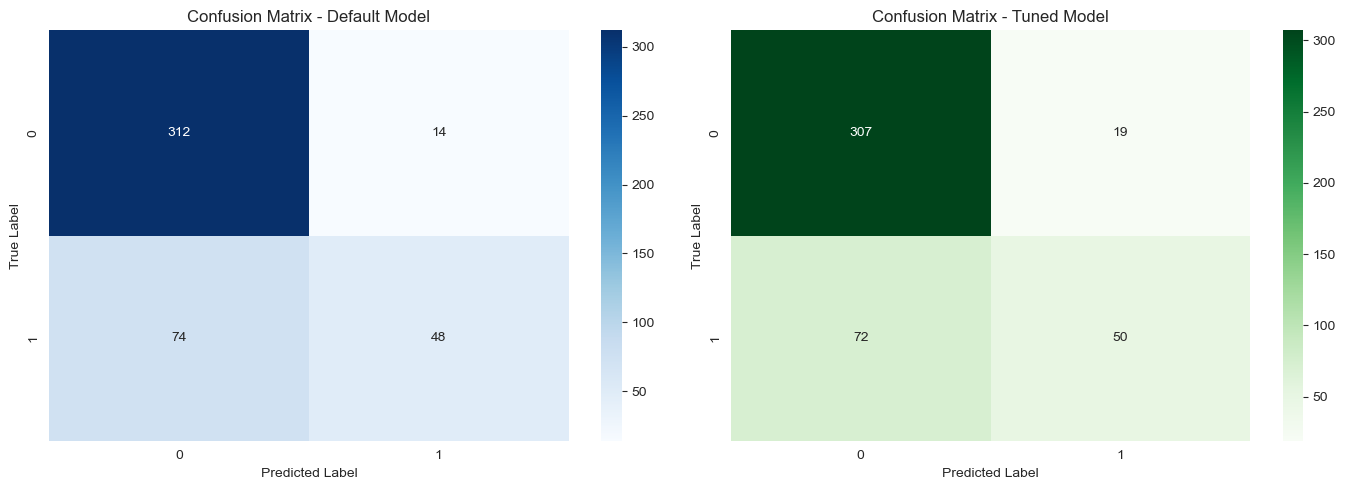

In [66]:
# Plot confusion matrices for both models
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Default model confusion matrix
cm_default = confusion_matrix(y_test, y_pred_default)
sns.heatmap(cm_default, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - Default Model')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Tuned model confusion matrix
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Confusion Matrix - Tuned Model')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

### 5.2 ROC Curve

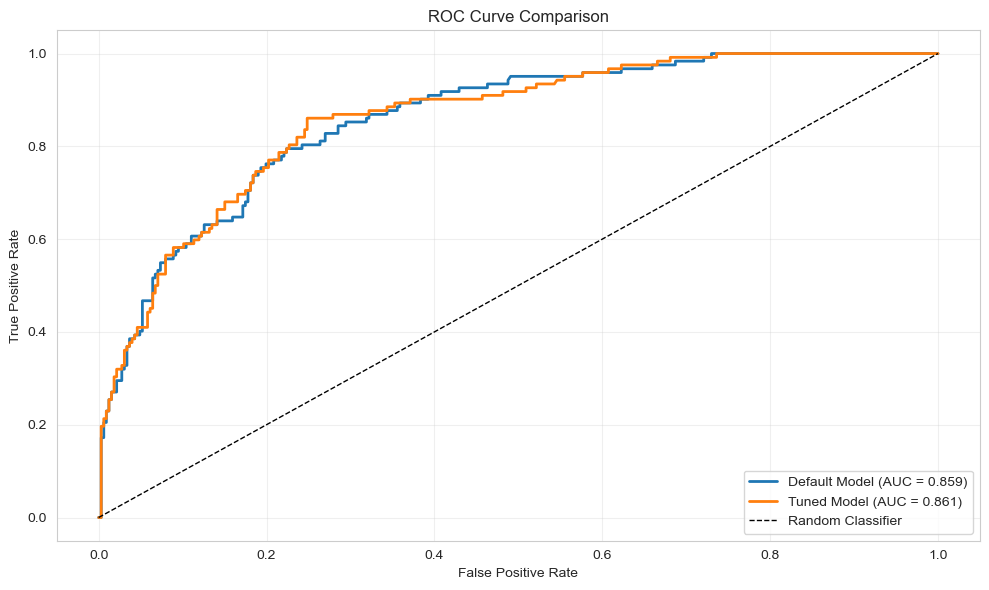

In [67]:
# Plot ROC curves for both models
plt.figure(figsize=(10, 6))

# Default model ROC
fpr_default, tpr_default, _ = roc_curve(y_test, y_pred_proba_default)
auc_default = roc_auc_score(y_test, y_pred_proba_default)
plt.plot(fpr_default, tpr_default, label=f'Default Model (AUC = {auc_default:.3f})', linewidth=2)

# Tuned model ROC
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_pred_proba_tuned)
auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned)
plt.plot(fpr_tuned, tpr_tuned, label=f'Tuned Model (AUC = {auc_tuned:.3f})', linewidth=2)

# Random classifier baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 5.3 Feature Importance Analysis

Top 10 Most Important Features:
               Feature  Importance
              MntWines    0.162049
         TotalSpending    0.092696
   NumCatalogPurchases    0.088997
AvgSpendingPerPurchase    0.063334
       NumWebPurchases    0.052096
     NumStorePurchases    0.051725
         TotalChildren    0.049754
     NumWebVisitsMonth    0.042352
              Teenhome    0.036083
        TotalPurchases    0.033230


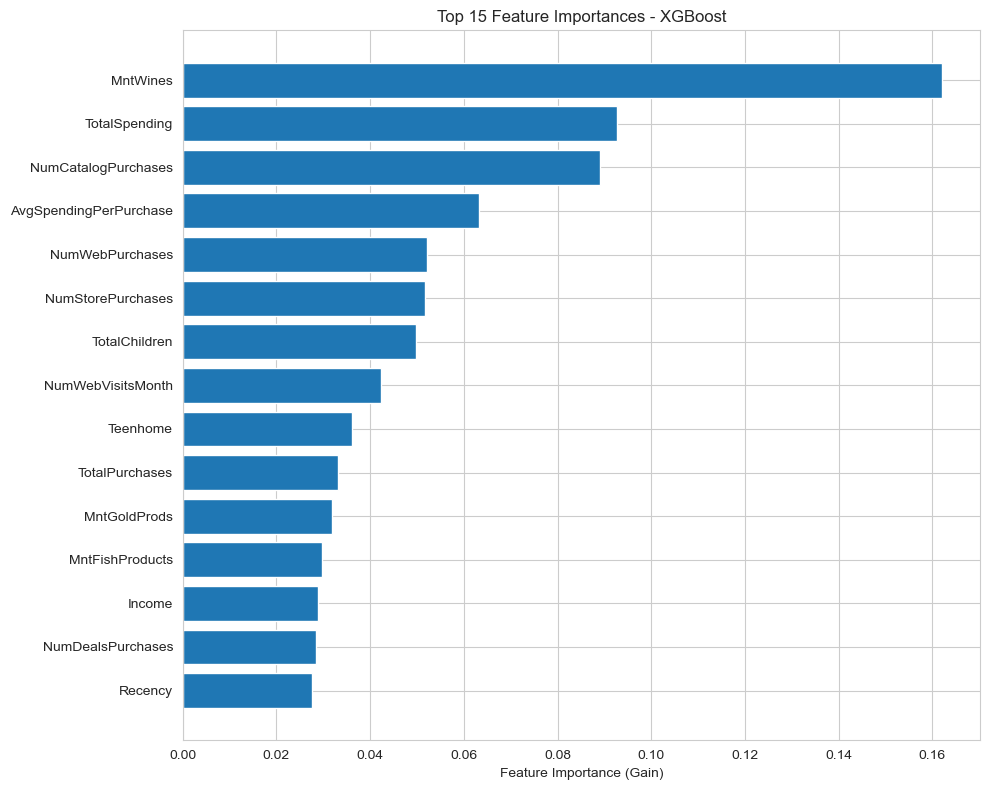

In [68]:
# Get feature importance from tuned model
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_tuned.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 10 Most Important Features:")
print("="*60)
print(feature_importance.head(10).to_string(index=False))

# Visualize top 15 features
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['Importance'])
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Feature Importance (Gain)')
plt.title('Top 15 Feature Importances - XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

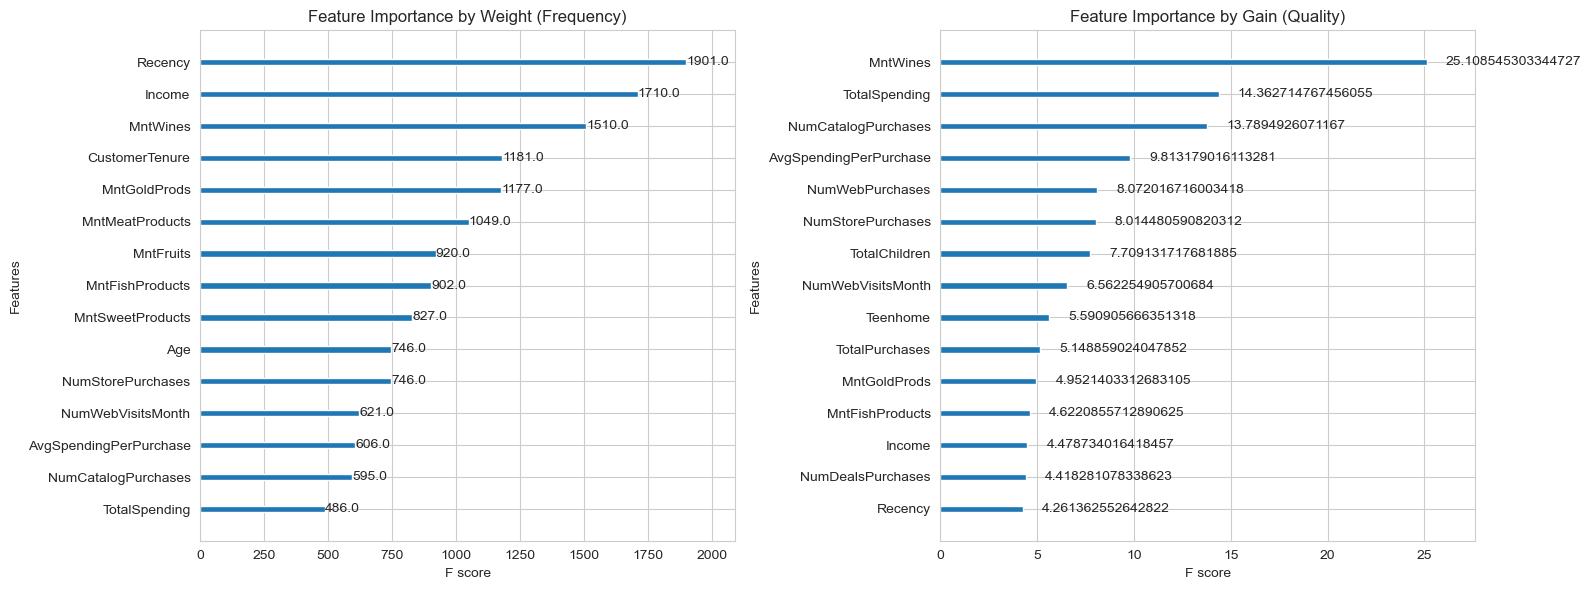

In [69]:
# XGBoost built-in feature importance plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot importance by weight (number of times feature is used)
xgb.plot_importance(xgb_tuned, max_num_features=15, importance_type='weight', ax=axes[0])
axes[0].set_title('Feature Importance by Weight (Frequency)')

# Plot importance by gain (average gain when feature is used)
xgb.plot_importance(xgb_tuned, max_num_features=15, importance_type='gain', ax=axes[1])
axes[1].set_title('Feature Importance by Gain (Quality)')

plt.tight_layout()
plt.show()

### 5.4 Classification Report

In [70]:
# Detailed classification report for tuned model
print("Classification Report - Tuned XGBoost Model")
print("="*60)
print(classification_report(y_test, y_pred_tuned, 
                          target_names=['Not Accepted', 'Accepted']))

Classification Report - Tuned XGBoost Model
              precision    recall  f1-score   support

Not Accepted       0.81      0.94      0.87       326
    Accepted       0.72      0.41      0.52       122

    accuracy                           0.80       448
   macro avg       0.77      0.68      0.70       448
weighted avg       0.79      0.80      0.78       448



## 6.0

In [71]:
# Examine the algorithm variant in our implementation
print("XGBoost Implementation Details:")
print("="*60)
print(f"Booster Type: {xgb_tuned.get_params()['booster']}")
print(f"Tree Method: {xgb_tuned.get_params()['tree_method']}")
print(f"Objective: {xgb_tuned.get_params()['objective']}")
print(f"\nRegularization Parameters:")
print(f"  - reg_alpha (L1): {xgb_tuned.get_params()['reg_alpha']}")
print(f"  - reg_lambda (L2): {xgb_tuned.get_params()['reg_lambda']}")
print(f"  - gamma (min split loss): {xgb_tuned.get_params()['gamma']}")
print(f"  - min_child_weight: {xgb_tuned.get_params()['min_child_weight']}")
print(f"\nSubsampling Parameters:")
print(f"  - subsample: {xgb_tuned.get_params()['subsample']}")
print(f"  - colsample_bytree: {xgb_tuned.get_params()['colsample_bytree']}")
print(f"  - colsample_bylevel: {xgb_tuned.get_params()['colsample_bylevel']}")
print(f"  - colsample_bynode: {xgb_tuned.get_params()['colsample_bynode']}")

XGBoost Implementation Details:
Booster Type: None
Tree Method: None
Objective: binary:logistic

Regularization Parameters:
  - reg_alpha (L1): None
  - reg_lambda (L2): None
  - gamma (min split loss): None
  - min_child_weight: 1

Subsampling Parameters:
  - subsample: 0.9
  - colsample_bytree: None
  - colsample_bylevel: None
  - colsample_bynode: 0.8


### 6.2 Default Hyperparameters and Convergence Behavior

In [73]:
# XGBoost Random Forest Mode - Default Hyperparameters
default_params_rf = {
    'num_parallel_tree': 100,      # Number of trees (RF specific!)
    'learning_rate': 1.0,           # MUST be 1.0 for RF mode
    'n_estimators': 1,              # MUST be 1 for RF mode
    'max_depth': 10,                # Maximum tree depth
    'min_child_weight': 1,          # Minimum sum of instance weight in child
    'gamma': 0,                     # Minimum loss reduction for split
    'subsample': 0.8,               # Bootstrap sampling ratio
    'colsample_bynode': 0.8,        # Feature sampling per split (not colsample_bytree!)
    'reg_alpha': 0,                 # L1 regularization
    'reg_lambda': 1,                # L2 regularization
}

print("XGBoost Random Forest Mode - Default Hyperparameters:")
print("="*60)
for param, value in default_params_rf.items():
    print(f"\n{param}: {value}")
    
    # Explain impact
    if param == 'num_parallel_tree':
        print("  Impact: Total number of trees built in parallel (like n_estimators in sklearn RF)")
    elif param == 'learning_rate':
        print("  Impact: MUST be 1.0 for RF mode - disables boosting shrinkage")
    elif param == 'n_estimators':
        print("  Impact: MUST be 1 for RF mode - all trees built in single round")
    elif param == 'max_depth':
        print("  Impact: Deeper trees capture complex patterns but risk overfitting")
    elif param == 'min_child_weight':
        print("  Impact: Higher values = more conservative, prevents overfitting")
    elif param == 'gamma':
        print("  Impact: Higher values = fewer splits, more conservative")
    elif param == 'subsample':
        print("  Impact: Bootstrap sampling ratio (0.8 = use 80% of data per tree)")
    elif param == 'colsample_bynode':
        print("  Impact: Feature sampling at each split (like max_features in sklearn)")
    elif param == 'reg_alpha':
        print("  Impact: L1 regularization for feature selection")
    elif param == 'reg_lambda':
        print("  Impact: L2 regularization for smoothing leaf weights")

XGBoost Random Forest Mode - Default Hyperparameters:

num_parallel_tree: 100
  Impact: Total number of trees built in parallel (like n_estimators in sklearn RF)

learning_rate: 1.0
  Impact: MUST be 1.0 for RF mode - disables boosting shrinkage

n_estimators: 1
  Impact: MUST be 1 for RF mode - all trees built in single round

max_depth: 10
  Impact: Deeper trees capture complex patterns but risk overfitting

min_child_weight: 1
  Impact: Higher values = more conservative, prevents overfitting

gamma: 0
  Impact: Higher values = fewer splits, more conservative

subsample: 0.8
  Impact: Bootstrap sampling ratio (0.8 = use 80% of data per tree)

colsample_bynode: 0.8
  Impact: Feature sampling at each split (like max_features in sklearn)

reg_alpha: 0
  Impact: L1 regularization for feature selection

reg_lambda: 1
  Impact: L2 regularization for smoothing leaf weights


### 6.3 Random Seed Control and Reproducibility

In [74]:
# Test reproducibility with same random seed
print("Testing Reproducibility with Fixed Random Seed:")
print("="*60)

results_seed = []

for run in range(3):
    model_repro = XGBClassifier(
        num_parallel_tree=100,  
        learning_rate=1.0, 
        random_state=42,  # Fixed seed
        n_estimators=1,
        max_depth=5,
        eval_metric='logloss' 
    )
    
    model_repro.fit(X_train, y_train, verbose=False)
    y_pred_repro = model_repro.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred_repro)
    
    results_seed.append(accuracy)
    print(f"Run {run+1}: Accuracy = {accuracy:.6f}")

print(f"\nStandard Deviation: {np.std(results_seed):.10f}")
print(f"All results identical: {len(set(results_seed)) == 1}")

# Test with different random seeds
print("\n" + "="*60)
print("Testing with Different Random Seeds:")
print("="*60)

results_diff_seeds = []
seeds = [42, 123, 456]

for seed in seeds:
    model_seed = XGBClassifier(
        num_parallel_tree=100,  
        learning_rate=1.0,      
        n_estimators=1,
        random_state=seed,
        max_depth=5,
        eval_metric='logloss'
    )
    
    model_seed.fit(X_train, y_train, verbose=False)
    y_pred_seed = model_seed.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred_seed)
    
    results_diff_seeds.append(accuracy)
    print(f"Seed {seed}: Accuracy = {accuracy:.6f}")

print(f"\nStandard Deviation: {np.std(results_diff_seeds):.6f}")
print(f"Mean Accuracy: {np.mean(results_diff_seeds):.6f}")

Testing Reproducibility with Fixed Random Seed:
Run 1: Accuracy = 0.801339
Run 2: Accuracy = 0.801339
Run 3: Accuracy = 0.801339

Standard Deviation: 0.0000000000
All results identical: True

Testing with Different Random Seeds:
Seed 42: Accuracy = 0.801339
Seed 123: Accuracy = 0.801339
Seed 456: Accuracy = 0.801339

Standard Deviation: 0.000000
Mean Accuracy: 0.801339


### 6.4 Ability to Inspect Intermediate States and Debug

In [75]:
# Demonstrate XGBoost's debugging and inspection capabilities
print("XGBoost Debugging and Inspection Capabilities:")
print("="*60)

# 1. Access to individual tree information
print("\n1. Tree Structure Information:")
print(f"   Number of trees: {len(xgb_tuned.get_booster().get_dump())}")
print(f"   Can dump tree structure: Yes")

# Get first tree structure
trees_dump = xgb_tuned.get_booster().get_dump()
print(f"\n   First tree (truncated):")
print("   " + "\n   ".join(trees_dump[0].split('\n')[:5]))

# 2. Feature importance access
print("\n2. Feature Importance Metrics:")
importance_types = ['weight', 'gain', 'cover']
for imp_type in importance_types:
    importance = xgb_tuned.get_booster().get_score(importance_type=imp_type)
    print(f"   - {imp_type}: {len(importance)} features scored")

# 3. Training history access
print("\n3. Training History:")
print(f"   Can access eval results: {hasattr(xgb_learning, 'evals_result')}")
print(f"   Metrics tracked: {list(xgb_learning.evals_result()['validation_0'].keys())}")

# 4. Model serialization and inspection
print("\n4. Model Serialization:")
print(f"   Can save to JSON: Yes")
print(f"   Can save to binary: Yes")
print(f"   Can export to text: Yes")

XGBoost Debugging and Inspection Capabilities:

1. Tree Structure Information:
   Number of trees: 150
   Can dump tree structure: Yes

   First tree (truncated):
   0:[MntWines<664] yes=1,no=2,missing=2
   	1:[NumCatalogPurchases<1] yes=3,no=4,missing=4
   		3:[AvgSpendingPerPurchase<16.2000008] yes=7,no=8,missing=8
   			7:[NumWebVisitsMonth<9] yes=15,no=16,missing=16
   				15:[MntFruits<19] yes=29,no=30,missing=30

2. Feature Importance Metrics:
   - weight: 23 features scored
   - gain: 23 features scored
   - cover: 23 features scored

3. Training History:
   Can access eval results: True
   Metrics tracked: ['logloss', 'error']

4. Model Serialization:
   Can save to JSON: Yes
   Can save to binary: Yes
   Can export to text: Yes


Visualizing Tree Structure (Tree #0):


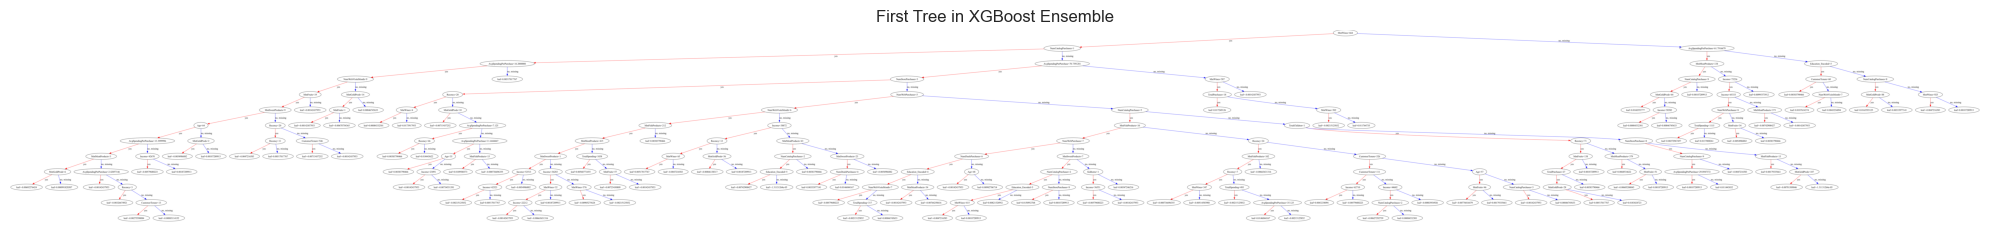


Note: Each tree shows:
  - Split conditions (e.g., 'TotalSpending < 100')
  - Leaf values (prediction contributions)
  - Cover (sum of second-order gradient)


In [76]:
# Visualize a single tree from the ensemble
print("Visualizing Tree Structure (Tree #0):")
fig, ax = plt.subplots(figsize=(20, 10))
xgb.plot_tree(xgb_tuned, num_trees=0, ax=ax)
plt.title('First Tree in XGBoost Ensemble')
plt.tight_layout()
plt.show()

print("\nNote: Each tree shows:")
print("  - Split conditions (e.g., 'TotalSpending < 100')")
print("  - Leaf values (prediction contributions)")
print("  - Cover (sum of second-order gradient)")

Analyzing Prediction Contributions for Sample Instances:


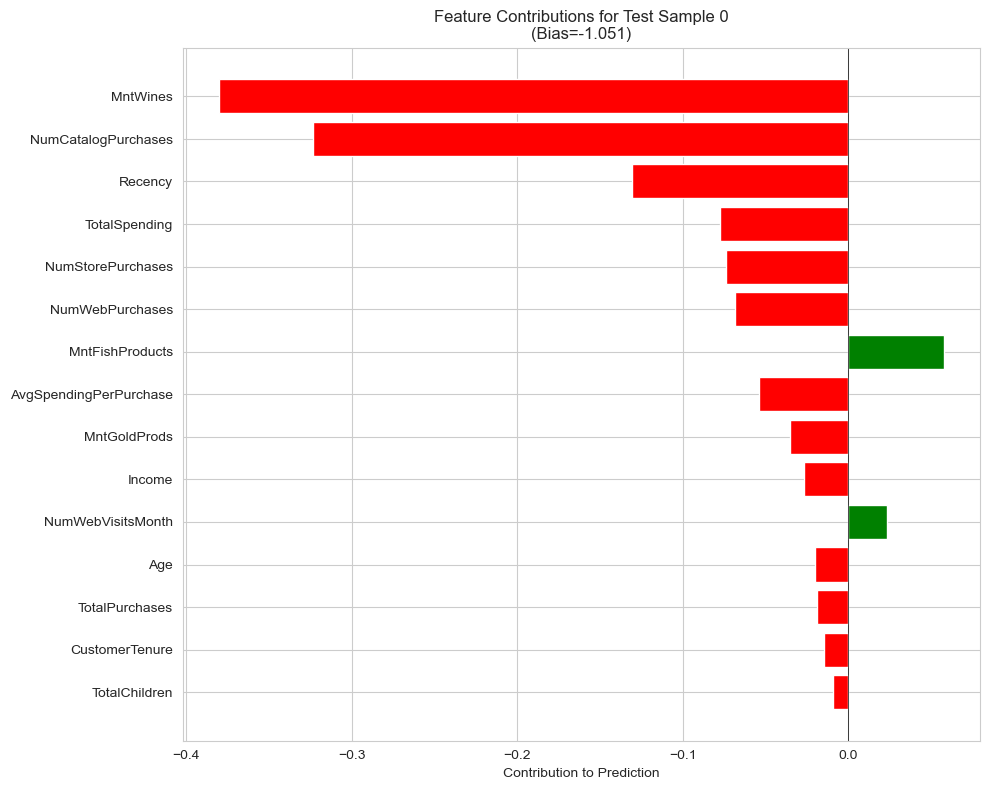


Prediction Breakdown for Sample 0:
  Bias (base score): -1.0514
  Sum of contributions: -1.1603
  Final prediction: -2.2116
  Predicted class: 0
  Actual class: 0


In [77]:
# Demonstrate prediction contributions (SHAP-like values)
print("Analyzing Prediction Contributions for Sample Instances:")
print("="*60)

# Get prediction contributions for first 3 test samples
sample_indices = [0, 1, 2]
X_test_sample = X_test.iloc[sample_indices]

# XGBoost can provide prediction contributions
booster = xgb_tuned.get_booster()
dtest_sample = xgb.DMatrix(X_test_sample, feature_names=X_test.columns.tolist())
contributions = booster.predict(dtest_sample, pred_contribs=True)

# Plot contributions for first sample
sample_idx = 0
contribs = contributions[sample_idx][:-1]  # Last value is bias
bias = contributions[sample_idx][-1]

# Get top contributing features
contrib_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Contribution': contribs
}).sort_values('Contribution', key=abs, ascending=False).head(15)

plt.figure(figsize=(10, 8))
colors = ['red' if x < 0 else 'green' for x in contrib_df['Contribution']]
plt.barh(range(len(contrib_df)), contrib_df['Contribution'], color=colors)
plt.yticks(range(len(contrib_df)), contrib_df['Feature'])
plt.xlabel('Contribution to Prediction')
plt.title(f'Feature Contributions for Test Sample {sample_idx}\n(Bias={bias:.3f})')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\nPrediction Breakdown for Sample {sample_idx}:")
print(f"  Bias (base score): {bias:.4f}")
print(f"  Sum of contributions: {contribs.sum():.4f}")
print(f"  Final prediction: {bias + contribs.sum():.4f}")
print(f"  Predicted class: {y_pred_tuned[sample_idx]}")
print(f"  Actual class: {y_test.iloc[sample_idx]}")

---
## 7. Framework Evaluation <a id='section7'></a>

### 7.1 Ease of Use and Environment Setup

In [82]:
# Demonstrate ease of use
print("XGBoost in Random Forest Mode - Key Parameters:")
print("=" * 60)
print(f"num_parallel_tree: 100  (builds trees in parallel)")
print(f"learning_rate: 1.0      (disables boosting shrinkage)")
print(f"n_estimators: 1         (single boosting round)")
print("\n" + "=" * 60)
print("XGBoost Default Parameters:")

# Minimal code example
print("""
# XGBoost in Random Forest mode
model = XGBClassifier(
    num_parallel_tree=100,
    learning_rate=1.0,
    n_estimators=1,
    subsample=0.8
)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
""")

# Sklearn integration
print("\n2. Scikit-learn Integration:")
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', XGBClassifier(random_state=42))
])

print("   Pipeline created successfully!")
print(f"   Steps: {[name for name, _ in pipeline.steps]}")

# Cross-validation integration
print("\n3. Cross-Validation Integration:")
cv_scores = cross_val_score(XGBClassifier(random_state=42), X_train, y_train, cv=5, scoring='f1')
print(f"   5-Fold CV F1-Scores: {cv_scores}")
print(f"   Mean: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

XGBoost in Random Forest Mode - Key Parameters:
num_parallel_tree: 100  (builds trees in parallel)
learning_rate: 1.0      (disables boosting shrinkage)
n_estimators: 1         (single boosting round)

XGBoost Default Parameters:

# XGBoost in Random Forest mode
model = XGBClassifier(
    num_parallel_tree=100,
    learning_rate=1.0,
    n_estimators=1,
    subsample=0.8
)
model.fit(X_train, y_train)
predictions = model.predict(X_test)


2. Scikit-learn Integration:
   Pipeline created successfully!
   Steps: ['scaler', 'classifier']

3. Cross-Validation Integration:
   5-Fold CV F1-Scores: [0.69273743 0.61988304 0.58241758 0.59090909 0.61627907]
   Mean: 0.6204 (+/- 0.0389)


### 7.2 Runtime and Scalability

Runtime Performance Analysis:
Size 20% (358 samples):
  Training: 0.077s | Prediction: 0.0055s
Size 40% (716 samples):
  Training: 0.078s | Prediction: 0.0052s
Size 60% (1075 samples):
  Training: 0.110s | Prediction: 0.0094s
Size 80% (1433 samples):
  Training: 0.100s | Prediction: 0.0050s
Size 100% (1792 samples):
  Training: 0.096s | Prediction: 0.0053s


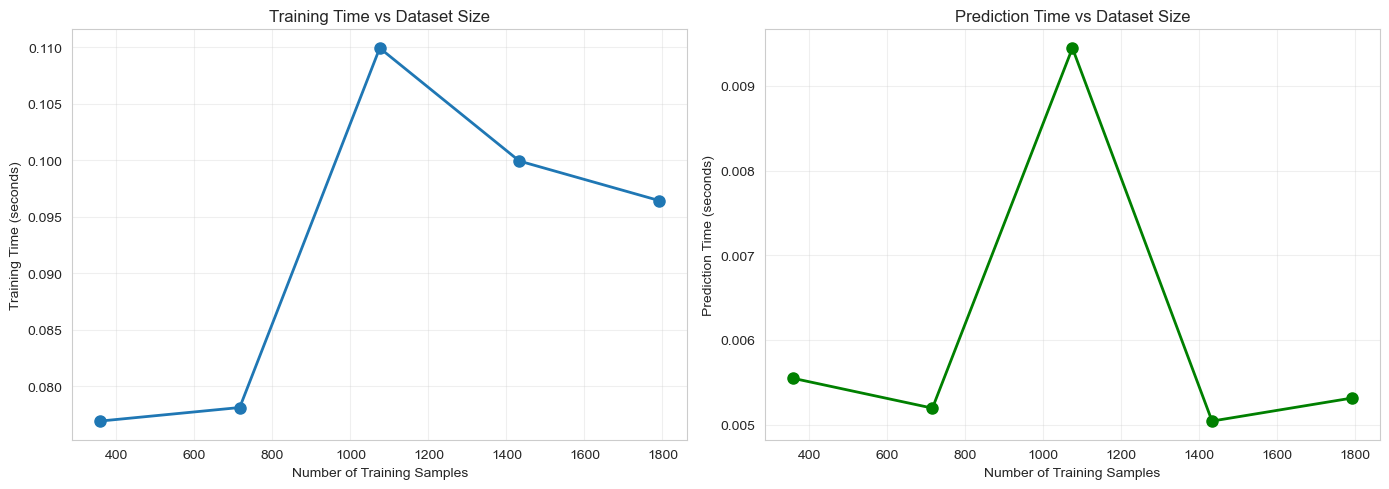

In [79]:
# Analyze runtime performance
print("Runtime Performance Analysis:")
print("="*60)

# Test with different dataset sizes
data_sizes = [0.2, 0.4, 0.6, 0.8, 1.0]
training_times = []
prediction_times = []

for size in data_sizes:
    # Subsample training data
    n_samples = int(len(X_train) * size)
    X_subset = X_train.iloc[:n_samples]
    y_subset = y_train.iloc[:n_samples]
    
    # Train
    model_size = XGBClassifier(num_parallel_tree=100, learning_rate=1.0, n_estimators=1, random_state=42, eval_metric='logloss')
    start = time.time()
    model_size.fit(X_subset, y_subset, verbose=False)
    train_time = time.time() - start
    
    # Predict
    start = time.time()
    _ = model_size.predict(X_test)
    pred_time = time.time() - start
    
    training_times.append(train_time)
    prediction_times.append(pred_time)
    
    print(f"Size {int(size*100)}% ({n_samples} samples):")
    print(f"  Training: {train_time:.3f}s | Prediction: {pred_time:.4f}s")

# Visualize scaling
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sample_counts = [int(len(X_train) * s) for s in data_sizes]

axes[0].plot(sample_counts, training_times, 'o-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Training Samples')
axes[0].set_ylabel('Training Time (seconds)')
axes[0].set_title('Training Time vs Dataset Size')
axes[0].grid(alpha=0.3)

axes[1].plot(sample_counts, prediction_times, 'o-', linewidth=2, markersize=8, color='green')
axes[1].set_xlabel('Number of Training Samples')
axes[1].set_ylabel('Prediction Time (seconds)')
axes[1].set_title('Prediction Time vs Dataset Size')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 7.3 GPU/CPU Support and Parallelism

System has 8 CPU cores available

Testing Multi-threading Performance:
n_jobs=1: 0.19s (speedup: 1.00x)
n_jobs=2: 0.12s (speedup: 1.54x)
n_jobs=4: 0.13s (speedup: 1.44x)
n_jobs=8: 0.17s (speedup: 1.15x)


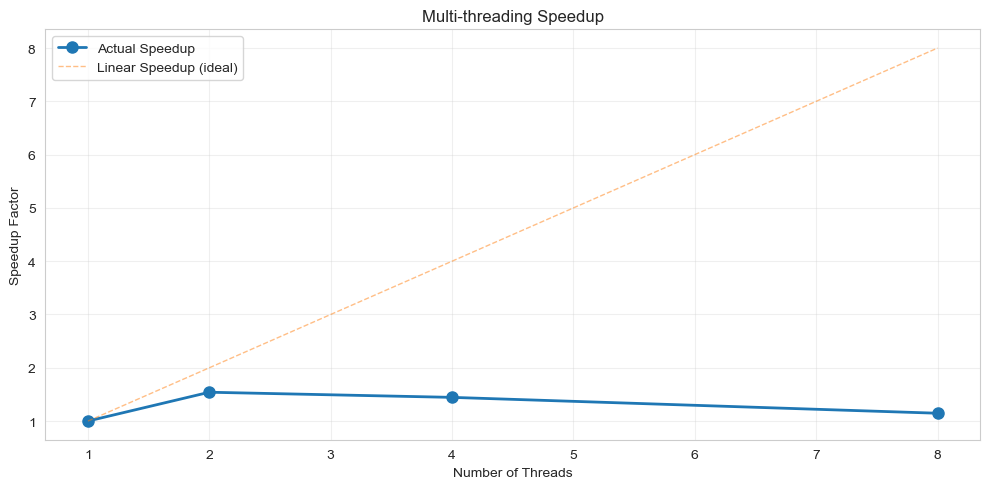


GPU Availability:
✅ GPU support is available
   To use GPU: set tree_method='gpu_hist'


In [83]:
# Demonstrate multi-threading performance
import multiprocessing

n_cores = multiprocessing.cpu_count()
print(f"System has {n_cores} CPU cores available")
print("\nTesting Multi-threading Performance:")
print("="*60)

thread_counts = [1, 2, 4, n_cores]
thread_times = []

for n_threads in thread_counts:
    if n_threads > n_cores:
        continue
    
    model_threads = XGBClassifier(
        num_parallel_tree=100, 
        learning_rate=1.0, 
        n_estimators=1,
        n_jobs=n_threads,
        random_state=42,
        eval_metric='logloss'
    )
    
    start = time.time()
    model_threads.fit(X_train, y_train, verbose=False)
    elapsed = time.time() - start
    
    thread_times.append(elapsed)
    speedup = thread_times[0] / elapsed if thread_times else 1.0
    
    print(f"n_jobs={n_threads}: {elapsed:.2f}s (speedup: {speedup:.2f}x)")

# Visualize speedup
if len(thread_times) > 1:
    plt.figure(figsize=(10, 5))
    speedups = [thread_times[0] / t for t in thread_times]
    actual_threads = thread_counts[:len(thread_times)]
    
    plt.plot(actual_threads, speedups, 'o-', linewidth=2, markersize=8, label='Actual Speedup')
    plt.plot(actual_threads, actual_threads, '--', linewidth=1, label='Linear Speedup (ideal)', alpha=0.5)
    plt.xlabel('Number of Threads')
    plt.ylabel('Speedup Factor')
    plt.title('Multi-threading Speedup')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

print("\nGPU Availability:")
print("="*60)
try:
    # Try to create a GPU model
    model_gpu = XGBClassifier(tree_method='gpu_hist')
    print("✅ GPU support is available")
    print("   To use GPU: set tree_method='gpu_hist'")
except Exception as e:
    print("⚠️ GPU support not available on this system")
    print(f"   Reason: {str(e)}")

---
## 8. Conclusions <a id='section8'></a>

In [ ]:
print("="*60)
print("Final Summary")
print("="*60)
print(f"\nDataset: Customer Personality Analysis")
print(f"Total Samples: {len(df)}")
print(f"Features Used: {len(feature_cols)}")
print(f"\nBest Model Configuration:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nFinal Test Set Performance:")
print(f"  Accuracy:  {accuracy_score(y_test, y_pred_tuned):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_tuned):.4f}")
print(f"  Recall:    {recall_score(y_test, y_pred_tuned):.4f}")
print(f"  F1-Score:  {f1_score(y_test, y_pred_tuned):.4f}")
print(f"  ROC-AUC:   {roc_auc_score(y_test, y_pred_proba_tuned):.4f}")
print(f"\nTop 3 Most Important Features:")
for i, row in feature_importance.head(3).iterrows():
    print(f"  {i+1}. {row['Feature']}: {row['Importance']:.4f}")
print("="*60)

FINAL SUMMARY

Dataset: Customer Personality Analysis
Total Samples: 2240
Features Used: 24

Best Model Configuration:
  colsample_bynode: 0.8
  max_depth: 15
  min_child_weight: 1
  num_parallel_tree: 150
  subsample: 0.9

Final Test Set Performance:
  Accuracy:  0.7969
  Precision: 0.7246
  Recall:    0.4098
  F1-Score:  0.5236
  ROC-AUC:   0.8607

Top 3 Most Important Features:
  5. MntWines: 0.1620
  18. TotalSpending: 0.0927
  13. NumCatalogPurchases: 0.0890

Analysis Complete!
